<a href="https://colab.research.google.com/github/Amit-Ramrakhyani/PyTorch-Notebooks/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options)



## 1. Make classification data and get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# Make a 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [5]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


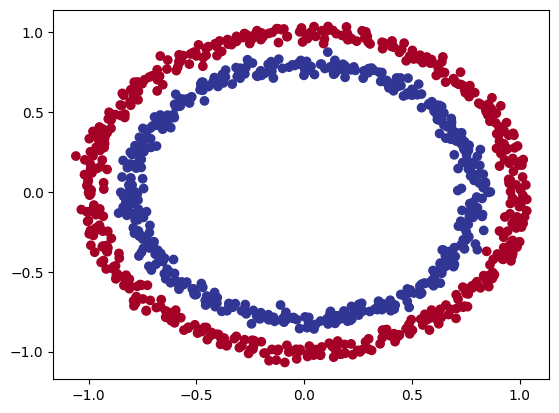

In [6]:
# Visualizing further
import matplotlib.pyplot as plt
plt.scatter(x=X[0:1000, 0],
            y=X[0:1000, 1],
            c=y[0:1000],
            cmap=plt.cm.RdYlBu)

Note: The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment on but still sizeable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and y: 1
Shapes for one sample of X: (2,) and y: ()


### 1.2 Turn data into tensors and create train and test splits

In [9]:
import torch
torch.__version__

'2.0.0+cu118'

In [10]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [11]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [12]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [13]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 0.2 = 20% of data will be testing data & 80% will be training data
                                                    random_state=42)

In [14]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify the blue and red dots.

To do so, we want to:
1. Setup device agnostic code so the code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [15]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [16]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

Let's create a model that:
1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear` layers that are capable of handling the shapes of the data
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of the model class and send it to the target `device`

In [17]:
X_train.shape

torch.Size([800, 2])

In [18]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    
    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # Takes in 2 features and upscales to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # Takes in 5 features from previous layer and outputs a single feature (same shape as y)

  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4. Instantiate an instance of the model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
device

'cuda'

In [20]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [21]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1),
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [22]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.4692,  0.5581],
                      [-0.1215,  0.4016],
                      [-0.0929, -0.0382],
                      [ 0.5881,  0.6685],
                      [ 0.1007, -0.2595]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.0864, -0.1155, -0.6552,  0.3445,  0.3836], device='cuda:0')),
             ('1.weight',
              tensor([[-0.3770, -0.2467, -0.1511, -0.1883, -0.4214]], device='cuda:0')),
             ('1.bias', tensor([-0.1972], device='cuda:0'))])

In [23]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-1.],
        [-1.],
        [-0.],
        [-1.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-1.]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [24]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### 2.1 Setup loss function and optimizer

Which loss function or optimizer to use? - Problem Specific

For example, for regression - MAE (Mean absolute error) or MSE (Mean sqaured error)

For classification - Binary Cross Entropy or Categorical Cross Entropy (Cross Entropy)

* For the loss function - `torch.nn.BECWithLogitsLoss()`

In [25]:
# Setup the loss function
# loss_fn = nn.BCELoss() # BCELoss = requires input to have gone through the sigmoid activation function prior to input to BCELoss

''' nn.Sequential(
    nn.Sigmoid(),
    nn.BCELoss()
) # Similar to nn.BCEWithLogitsLoss() '''

loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [26]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train Model

Building a training loop to train the model

1. Forward pass
2. Calculate the loss
3. optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

The model outputs are going to be raw **logits**.

Convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for muliclass classification)

Then convert the model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`

In [27]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.5728],
        [-0.6352],
        [-0.2756],
        [-0.6576],
        [-0.0633]], device='cuda:0')

In [28]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [29]:
# Use the sigmoid activation funcion on the model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3606],
        [0.3463],
        [0.4315],
        [0.3413],
        [0.4842]], device='cuda:0')

For the prediction probability values, perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [30]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs ->  pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0')

In [31]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a training and testing loop

In [32]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):

  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> prd label

  # 2. Caluculate loss/accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), # nn.BCELoss expects prediction probabilities as input
  #                y_train)
  loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss Backward
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing 
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Caluclate test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
    
    # print out what's happenin'
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71310 | Acc: 48.00% | Test loss: 0.70587 | Test Acc: 48.00%
Epoch: 10 | Loss: 0.70264 | Acc: 45.88% | Test loss: 0.69698 | Test Acc: 47.00%
Epoch: 20 | Loss: 0.69847 | Acc: 47.00% | Test loss: 0.69391 | Test Acc: 49.00%
Epoch: 30 | Loss: 0.69656 | Acc: 47.75% | Test loss: 0.69288 | Test Acc: 52.00%
Epoch: 40 | Loss: 0.69553 | Acc: 48.38% | Test loss: 0.69259 | Test Acc: 51.50%
Epoch: 50 | Loss: 0.69489 | Acc: 49.12% | Test loss: 0.69257 | Test Acc: 50.00%
Epoch: 60 | Loss: 0.69444 | Acc: 49.38% | Test loss: 0.69267 | Test Acc: 49.50%
Epoch: 70 | Loss: 0.69411 | Acc: 49.88% | Test loss: 0.69281 | Test Acc: 49.50%
Epoch: 80 | Loss: 0.69386 | Acc: 50.00% | Test loss: 0.69296 | Test Acc: 48.50%
Epoch: 90 | Loss: 0.69367 | Acc: 50.62% | Test loss: 0.69312 | Test Acc: 48.00%


## 4. Make predictions and evaluate the model

To visualize the data, importing a function called `plot_decision_boundary()`

In [33]:
import requests
from pathlib import Path

# Downloading helper functions from learn PyTorch repo (if it's not already downloaded)
if Path("helper_function.py").is_file():
  print("helper_function.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

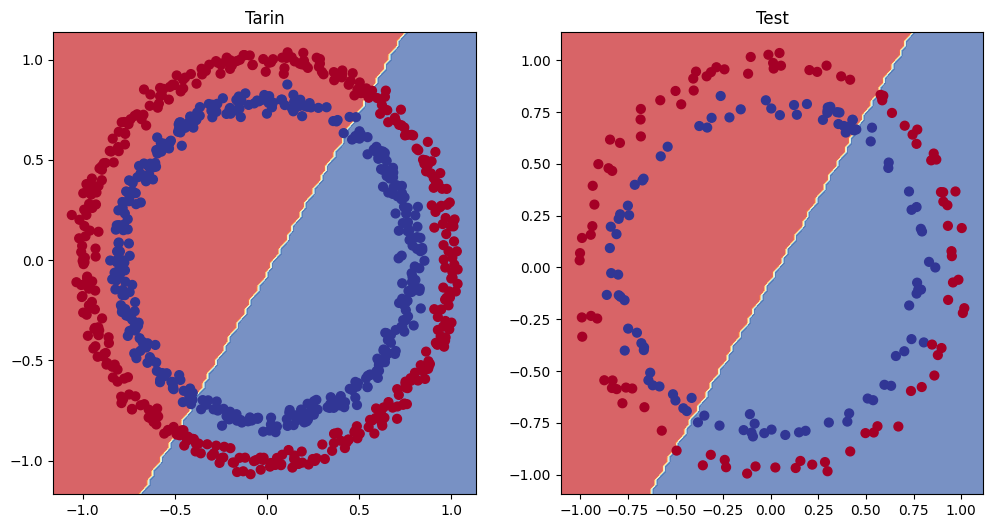

In [34]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Tarin")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model's perspective)

* Adding more layers - give the model more chances to learn about patterns in the data
* Increasing the number of hidden units - go from 5 hidden units to 10 hidden units
* Fitting for longer - increasing the number of epochs
* Changing/adding the activation functions
* Changing the learning rate
* Changing the loss/optimization function

These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values a machine learning engineer and data scientists can chnage, they are referred as **hyperparameters**.

Improving the model by:
* Adding more hidden units: 5 -> 10
* Increasing the number of layers: 2 -> 3
* Increasing the number of epochs: 100 -> 1000
 

In [35]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    # return z
    return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations leverages speed ups where possible behind the scenes

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [36]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [37]:
# Creating a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Traing for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training 
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_1.eval()

  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate the loss
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
    
  # Print out what's happenin'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test Accuracy: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test Accuracy: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test Accuracy: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test Accuracy: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test Accuracy: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test Accuracy: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test Accuracy: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test Accuracy: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test Accuracy: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test Accuracy: 46.00%


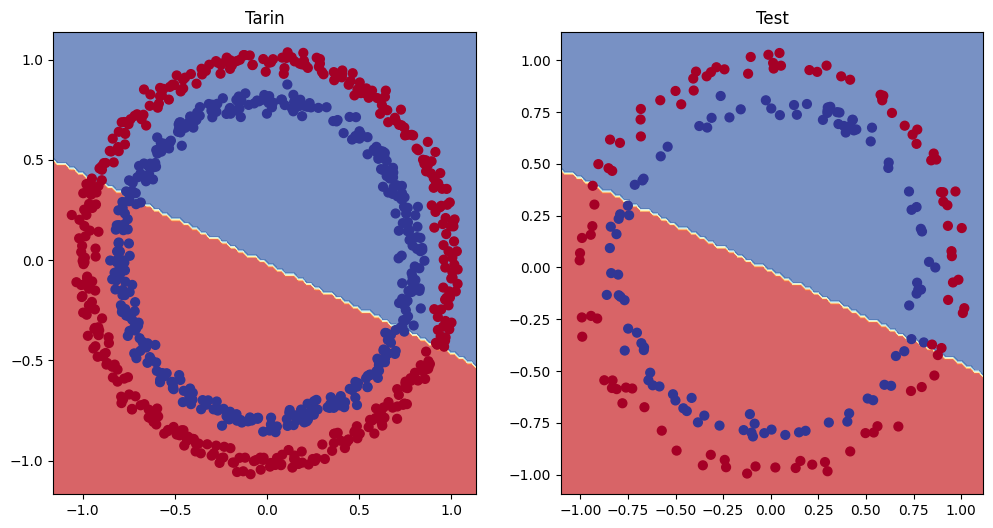

In [38]:
# Plot the decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Tarin")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if the model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem.

In [39]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias 

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [40]:
# Create train and test split
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each
len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

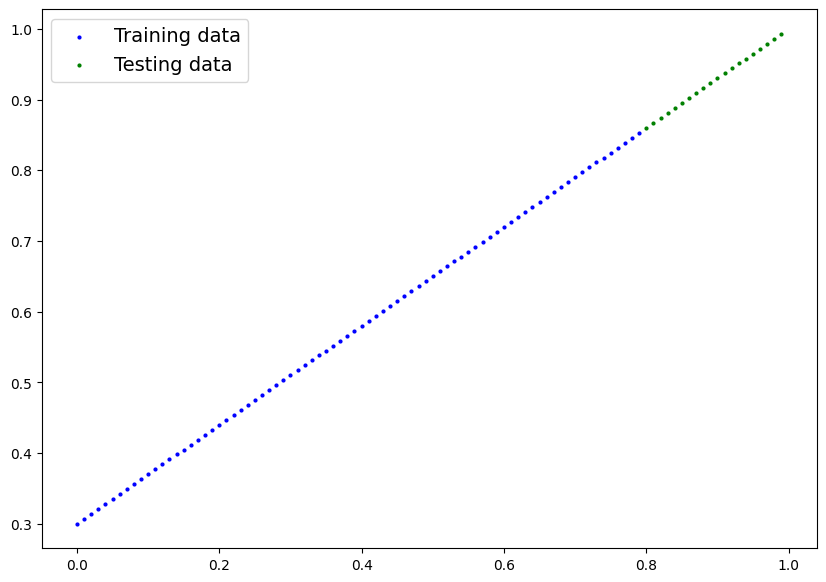

In [41]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

### 5.2 Adjusting `model_1` to fit a straight line

In [42]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [43]:
# Loss function and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [44]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  # Print out what's happenin'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986 | Test loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test loss: 0.00360


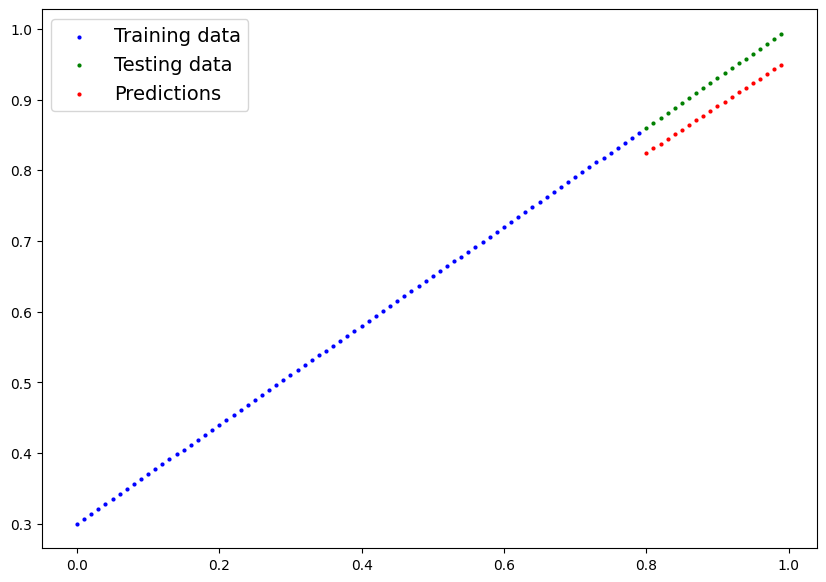

In [45]:
# Turn on evaluation mode 
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

## 6. Non-Linearity

### 6.1 Recreating non-linear data (red and blue circles)

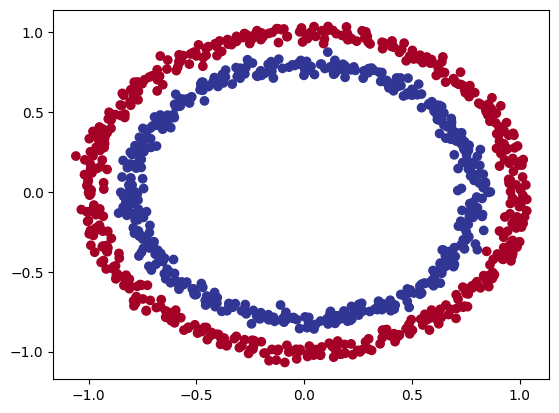

In [46]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [47]:
# Convert data to tensors and then to rain and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

Artificial neural networks are a large combination of linear and non-linear functions which are potentially able to find patterns in data.

In [48]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # ReLU is a non-linear activation function

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [49]:
## Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

### 6.3 Training a model with non-linearity


In [50]:
# Random Seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 2000

for epoch in range(epochs):
  ### Training
  model_3.train()

  # 1. Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss Backward
  loss.backward()

  # 5. Step the Optimizer
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
    
  # Print out what's happenin'
  if epoch % 200 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test loss: 0.69319, Test Accuracy: 50.00%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test loss: 0.68940, Test Accuracy: 55.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test loss: 0.68411, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test loss: 0.67285, Test Accuracy: 56.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test loss: 0.64757, Test Accuracy: 67.50%
Epoch: 1000 | Loss: 0.56818, Accuracy: 87.75% | Test loss: 0.57378, Test Accuracy: 86.50%
Epoch: 1200 | Loss: 0.37056, Accuracy: 97.75% | Test loss: 0.40595, Test Accuracy: 92.00%
Epoch: 1400 | Loss: 0.17180, Accuracy: 99.50% | Test loss: 0.22108, Test Accuracy: 97.50%
Epoch: 1600 | Loss: 0.09123, Accuracy: 99.88% | Test loss: 0.12741, Test Accuracy: 99.50%
Epoch: 1800 | Loss: 0.05773, Accuracy: 99.88% | Test loss: 0.08672, Test Accuracy: 99.50%


### 6.4 Evaluating a model trained with non-linear activation functions

In [51]:
# Make predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

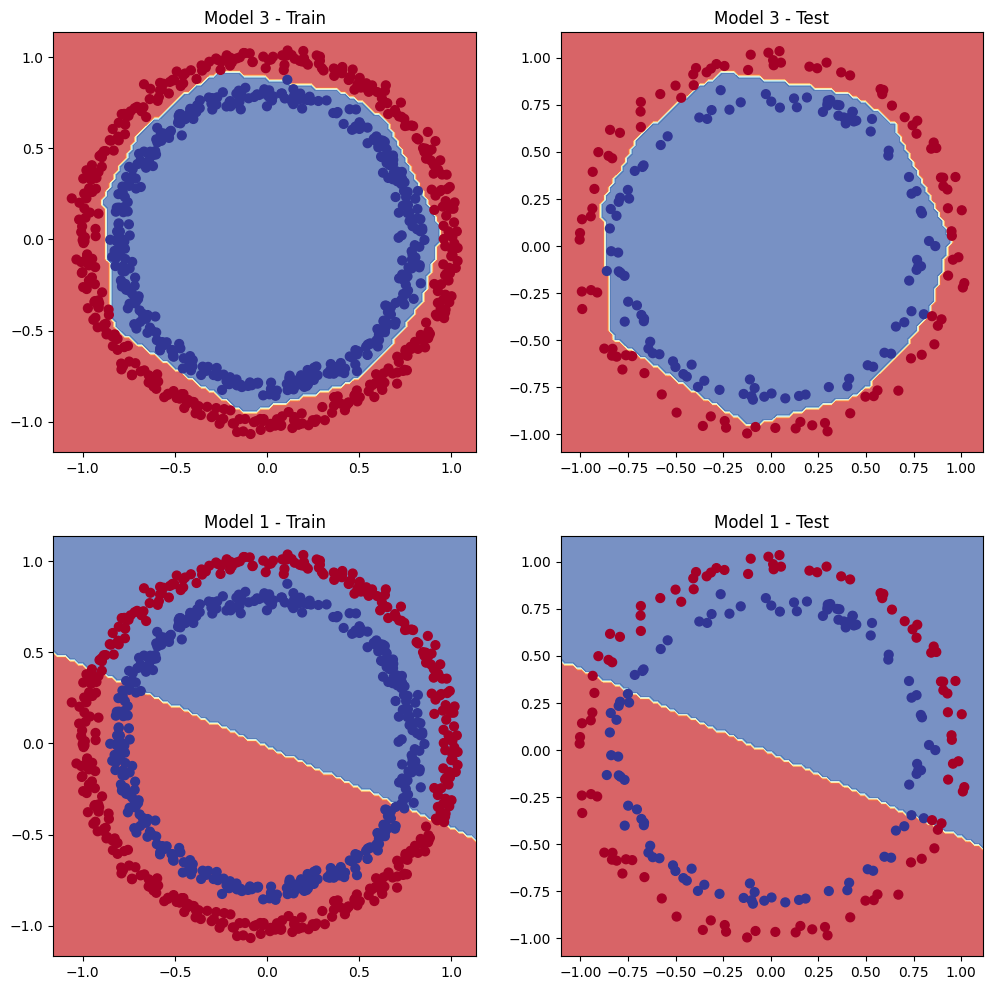

In [52]:
# Plotting the decision boundary
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.title("Model 3 - Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(2, 2, 2)
plt.title("Model 3 - Test")
plot_decision_boundary(model_3, X_test, y_test)
plt.subplot(2, 2, 3)
plt.title("Model 1 - Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(2, 2, 4)
plt.title("Model 1 - Test")
plot_decision_boundary(model_1, X_test, y_test)

## 7. Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And these tools are linear and non-linear functions.

In [53]:
# Create a tensor 
A = torch.arange(-10, 10, 1.0)
A.dtype

torch.float32

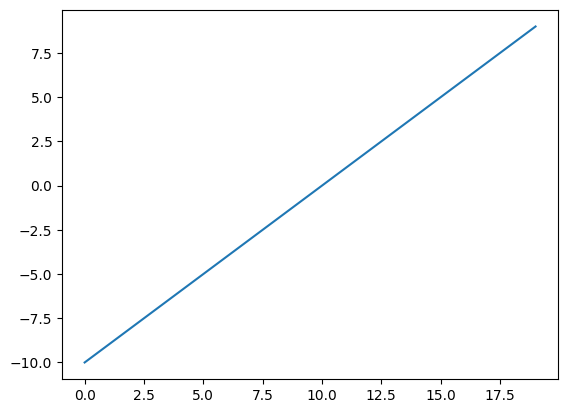

In [54]:
# Visualize the tensor
plt.plot(A)

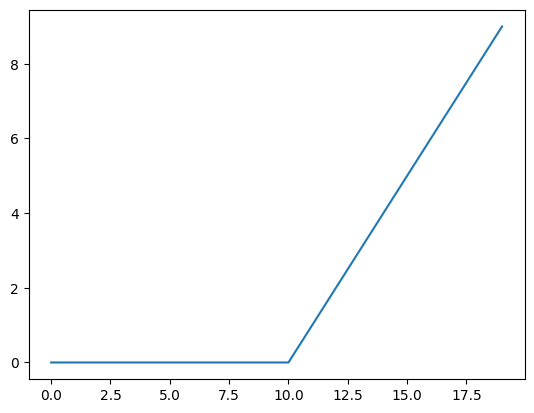

In [55]:
plt.plot(torch.relu(A))

In [56]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x) # inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

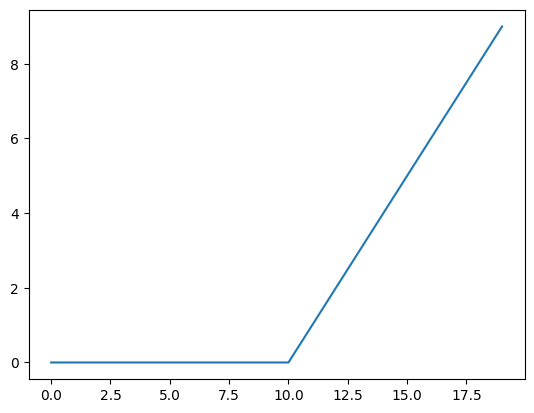

In [57]:
# Plot ReLU activation function
plt.plot(relu(A))

In [58]:
# Creating a custom sigmoid function
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

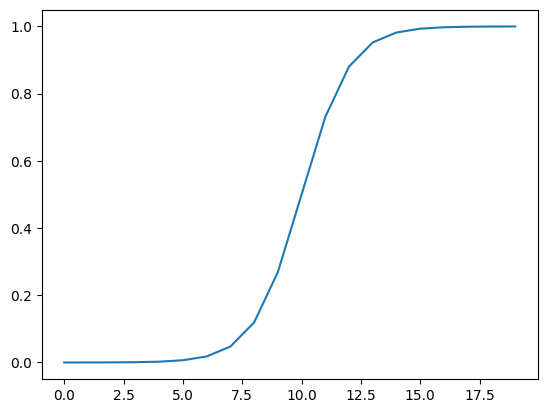

In [59]:
plt.plot(torch.sigmoid(A))

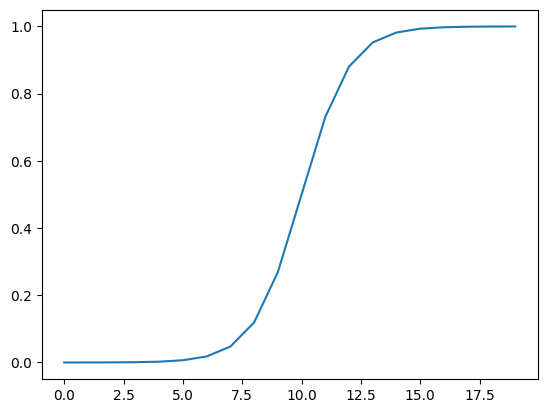

In [60]:
plt.plot(sigmoid(A))

## 8. Multi-class classification problem

### 8.1 Creating a toy multi-class dataset

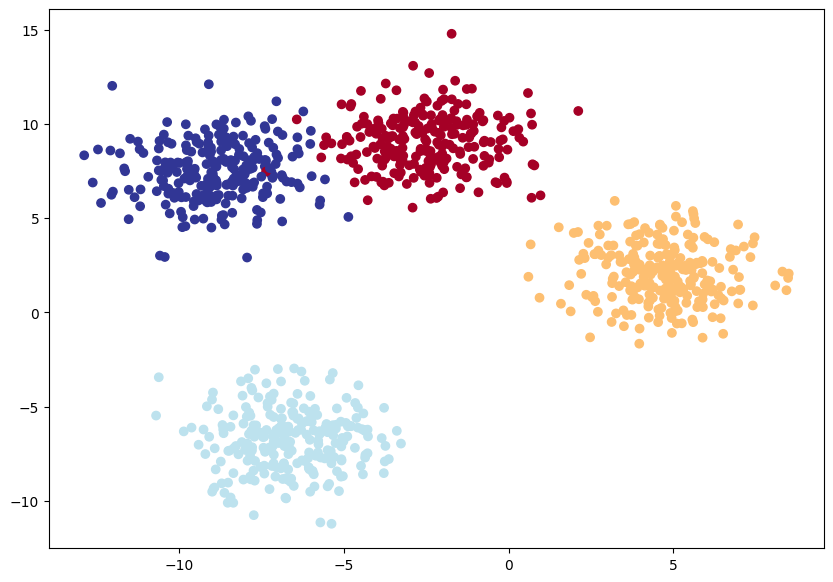

In [80]:
# Import dependencies
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs # https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Creating multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # giving the clusters a little shake up
                            random_state=RANDOM_SEED)

# 2. Turning data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Putting the data on the device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# 5. Plotting data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multi-class classification model in PyTorch

In [81]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [103]:
# Building a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initializes multi-class classification model.
    
    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of output features (number of output classes)
      hidden_units (int): Number of hidden units between layers, default 8

    Returns:

    Error:

    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )
  def forward(self, x):
    return self.linear_layer_stack(x)

# Creating an instance of BlobModel and sending it to the target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [104]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0], device='cuda:0'))

In [105]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3], device='cuda:0')

### 8.3 Creating a loss function and an optimizer for a multi-class classification model

In [106]:
# Creating a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Creating an optimizer for multi-class classification
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In order to evaluate and train and test the model, we need to convert the model's outputs (logits) to prediction probabilities and then to prdiction labels.

Logits (raw otupus of the model) -> Pred probs (use `torch.softmax`) -> Pred labels (take the argmax of the prediction probabilities)

In [107]:
# Raw outputs of the model (logits)
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

y_logits[:5]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')

In [108]:
y_blob_test[:5]

tensor([1, 3, 2, 1, 0], device='cuda:0')

In [109]:
# Converting the model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [110]:
# Converting the model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [111]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch model

In [112]:
# Fit the multi-class model to the data

# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

# Loop through data
for epoch in range(epochs):
  ### Training
  model_4.train()

  # 1. Forward pass
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss Backward (Backpropagation)
  loss.backward()

  # 5. Optimizer step (Gradient Descent)
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_preds)
  
  # Print out what's happenin'
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.15883, Accuracy: 40.38% | Test loss: 1.07554, Test Accuracy: 48.00%
Epoch: 10 | Loss: 0.64476, Accuracy: 96.75% | Test loss: 0.66069, Test Accuracy: 97.50%
Epoch: 20 | Loss: 0.42535, Accuracy: 98.50% | Test loss: 0.43074, Test Accuracy: 100.00%
Epoch: 30 | Loss: 0.25294, Accuracy: 99.12% | Test loss: 0.24508, Test Accuracy: 99.50%
Epoch: 40 | Loss: 0.11232, Accuracy: 99.25% | Test loss: 0.10229, Test Accuracy: 99.50%
Epoch: 50 | Loss: 0.06627, Accuracy: 99.25% | Test loss: 0.05848, Test Accuracy: 99.50%
Epoch: 60 | Loss: 0.05068, Accuracy: 99.25% | Test loss: 0.04293, Test Accuracy: 99.50%
Epoch: 70 | Loss: 0.04300, Accuracy: 99.25% | Test loss: 0.03491, Test Accuracy: 99.50%
Epoch: 80 | Loss: 0.03836, Accuracy: 99.25% | Test loss: 0.02988, Test Accuracy: 99.50%
Epoch: 90 | Loss: 0.03525, Accuracy: 99.25% | Test loss: 0.02663, Test Accuracy: 99.50%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [113]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]], device='cuda:0')

In [115]:
# Logits -> Prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.3438e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
        [9.9825e-01, 1.4575e-03, 1.5998e-05, 2.7210e-04]], device='cuda:0')

In [119]:
# Prediction probabilities -> Prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10], y_blob_test[:10]

(tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'))

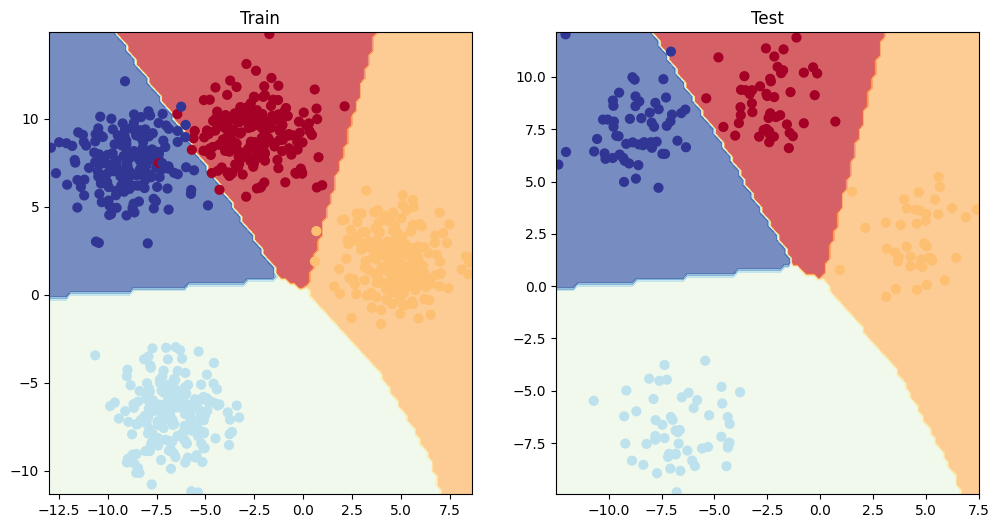

In [120]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)